In [ ]:
import numpy as np 
import pandas as pd
import keras
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from  keras.preprocessing.sequence import pad_sequences
from keras.models import *
from keras.layers import *
from keras.losses import *
from keras.callbacks import *
from keras.optimizers import *
import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score
from gensim.test.utils import common_texts, get_tmpfile
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

df = pd.read_csv('/content/drive/MyDrive/Project/NLP/data/train.csv')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [ ]:
#N umber of sentences
sentence_split = re.compile("[.!?'\";]")
df['num_sentences'] = df['text'].apply(lambda x: len(sentence_split.split(x)))
df['num_sentences'].describe()

count    54879.000000
mean         5.158622
std          4.023919
min          1.000000
25%          3.000000
50%          4.000000
75%          6.000000
max         79.000000
Name: num_sentences, dtype: float64

In [ ]:
# Number of words
df['num_words'] = df['text'].apply(lambda x: len(x.split(' ')))
df['num_words'].describe()

count    54879.000000
mean        42.257184
std         50.811812
min          5.000000
25%         12.000000
50%         22.000000
75%         50.000000
max        472.000000
Name: num_words, dtype: float64

In [ ]:
labelEncoder = LabelEncoder().fit(df['author'])
df['author_id'] = labelEncoder.transform(df['author'])

def gen_ngram(tokens, n):
    length = len(tokens)
    for i in range(2, n+1):
        for j in range(0, length+1-i):
            tokens.append('+'.join(tokens[j:j+i]))
    return tokens
    
def preprocess_text(text, stem_func=None, stop_words=set()):
    text = nltk.tokenize.word_tokenize(text)
    text = [w for w in text if not w in stop_words]
    if stem_func!=None:
        text = [stem_func(w) for w in text]
    return ' '.join(text)
wnl = nltk.stem.wordnet.WordNetLemmatizer()

df['text_proc'] = df['text'].apply(lambda x: preprocess_text(x, wnl.lemmatize, set()))
df['pos_tags'] = df['text_proc'].apply(lambda x: ' '.join([y[1] for y in nltk.pos_tag(x.split(' '))]))
df['text_proc'].head().apply(lambda x: len(x.split(' ')))
df['pos_tags'].head().apply(lambda x: len(x.split(' ')))
df.head()

,index,text,author,num_sentences,num_words,author_id,text_proc,pos_tags
0,0,"He was almost choking. There was so much, so m...",3,5,46,3,"He wa almost choking . There wa so much , so m...","PRP VBZ RB NN . EX VBZ RB JJ , RB RB PRP VBD T..."
1,1,"“Your sister asked for it, I suppose?”",2,2,7,2,"“ Your sister asked for it , I suppose ? ”","VB PRP$ NN VBD IN PRP , PRP VBP . NN"
2,2,"She was engaged one day as she walked, in per...",1,3,58,1,"She wa engaged one day a she walked , in perus...","PRP VBD JJ CD NN DT PRP VBD , IN VBG NNP NNP V..."
3,3,"The captain was in the porch, keeping himself ...",4,10,58,4,"The captain wa in the porch , keeping himself ...","DT NN NN IN DT NN , VBG PRP RB IN IN DT NN IN ..."
4,4,"“Have mercy, gentlemen!” odin flung up his han...",3,10,39,3,"“ Have mercy , gentleman ! ” odin flung up his...","NNS VBP VBN , NN . JJ NN VBD RP PRP$ NN . JJ N..."


In [ ]:
bigrams = [' '.join(gen_ngram(sentence.split(' '), 2)) for sentence in df['text_proc']]
tokenizer = Tokenizer(filters='', lower=False, split=' ')
tokenizer.fit_on_texts(bigrams)

y = df['author_id'].values
X = tokenizer.texts_to_sequences(bigrams)
X = pad_sequences(X)
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.1)

In [ ]:
model1 = Sequential([
                     InputLayer(X.shape[1],),
                     Embedding(input_dim=np.max(X)+1, output_dim=40, input_length=X.shape[1]),
                     Dropout(.5),
                     Conv1D(128, 7, padding="valid", activation="relu", strides=3),
                     # Conv1D(128, 7, padding="valid", activation="relu", strides=3),    
                     GlobalMaxPooling1D(),
                     Dropout(.5),
                     Dense(5, activation='softmax')
                     ])

model1.summary()

"""
model1 = Sequential()
model1.add(InputLayer((X.shape[1],)))
model1.add(Embedding(input_dim=np.max(X)+1, output_dim=40, input_length=X.shape[1]))
model1.add(GlobalAveragePooling1D())
model1.add(Dropout(0.5))
model1.add(Dense(3, activation='softmax'))
model1.summary()
"""

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 1057, 40)          22254200  
_________________________________________________________________
dropout_32 (Dropout)         (None, 1057, 40)          0         
_________________________________________________________________
conv1d_32 (Conv1D)           (None, 351, 128)          35968     
_________________________________________________________________
global_max_pooling1d_16 (Glo (None, 128)               0         
_________________________________________________________________
dropout_33 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 5)                 645       
Total params: 22,290,813
Trainable params: 22,290,813
Non-trainable params: 0
_________________________________________

"\nmodel1 = Sequential()\nmodel1.add(InputLayer((X.shape[1],)))\nmodel1.add(Embedding(input_dim=np.max(X)+1, output_dim=40, input_length=X.shape[1]))\nmodel1.add(GlobalAveragePooling1D())\nmodel1.add(Dropout(0.5))\nmodel1.add(Dense(3, activation='softmax'))\nmodel1.summary()\n"

In [ ]:
# 첫번째 모델
#model1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])
# mean_squared_error
import tensorflow as tf

model1.compile(optimizer = tf.keras.optimizers.Adam(),
              loss = 'sparse_categorical_crossentropy',
               metrics = ['accuracy'])

epochs=100

history = model1.fit(X_train, y_train, 
          epochs=epochs, 
          validation_data=(X_validation, y_validation),
          batch_size=512,
          callbacks=[EarlyStopping(monitor='val_loss', min_delta=0.001, patience=3,
                   verbose=1, mode='min', baseline=None, restore_best_weights=True)])

Epoch 1/100
97/97 [==============================] - 29s 291ms/step - loss: 1.5772 - accuracy: 0.2638 - val_loss: 1.4869 - val_accuracy: 0.4187
Epoch 2/100
97/97 [==============================] - 28s 284ms/step - loss: 1.3985 - accuracy: 0.4353 - val_loss: 1.0673 - val_accuracy: 0.6163
Epoch 3/100
97/97 [==============================] - 28s 285ms/step - loss: 0.9855 - accuracy: 0.6321 - val_loss: 0.7687 - val_accuracy: 0.7385
Epoch 4/100
97/97 [==============================] - 27s 283ms/step - loss: 0.6479 - accuracy: 0.7789 - val_loss: 0.6426 - val_accuracy: 0.7746
Epoch 5/100
97/97 [==============================] - 28s 284ms/step - loss: 0.4000 - accuracy: 0.8804 - val_loss: 0.5931 - val_accuracy: 0.7899
Epoch 6/100
97/97 [==============================] - 28s 285ms/step - loss: 0.2379 - accuracy: 0.9330 - val_loss: 0.5922 - val_accuracy: 0.7919
Epoch 7/100
97/97 [==============================] - 27s 283ms/step - loss: 0.1516 - accuracy: 0.9594 - val_loss: 0.6024 - val_accuracy:

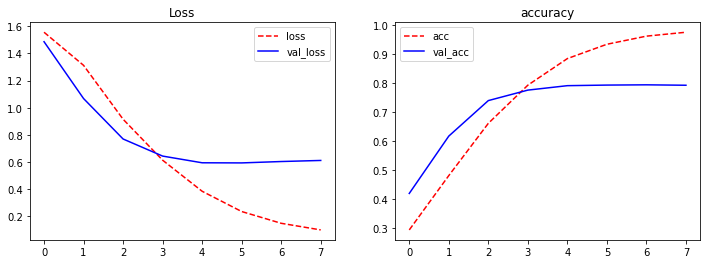

In [ ]:
# callbacks=[EarlyStopping(patience=3, monitor='val_loss')])
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.title("Loss")
plt.plot(history.history['loss'], 'r--', label = 'loss')
plt.plot(history.history['val_loss'], 'b-', label = 'val_loss')
plt.legend()

plt.subplot(1,2,2)
plt.title("accuracy")
plt.plot(history.history['accuracy'], 'r--', label = 'acc')
plt.plot(history.history['val_accuracy'], 'b-', label = 'val_acc')
plt.legend()